# OutOfStock
## Model Training Recipe 
v2019-04-24.02 - add metrics tags

In [1]:
# setup for training AND prediction
import analitico
import analitico.plugin
import s24.plugin

from analitico.pandas import *

import numpy as np
from scipy import stats

# pass api token to create factory
factory = analitico.authorize("tok_s24_579E5hOWw7k8")

def sample(df):
    return df.sample(n=4)

import datetime
print(datetime.datetime.utcnow())

2019-05-09 07:40:05.665300


In [2]:
import missingno as msno
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [3]:
%config Application.log_level='DEBUG'
%config Application.log_level='INFO'
import logging
logging.getLogger().setLevel(logging.INFO)
log = logging.getLogger()
log.debug('Test debug')
log.info('Test info')

In [4]:
action = "train"

y_label = "pick_time.min"

# data used for sample prediction
data = [{
        "order_fulfillment_type": 1,
        "order_deliver_at_start": "2018-08-27 19:00:00",
        "courier_id": 109135.0,
        "odt_items_total": 12,
        "odt_items_with_variable_weight": 0,
        "store_name": "esselunga",
        "store_area": "MI6",
        "store_province": "MI",
        "store_ref_id": 5042,
        "courier_area": "MI13",
        "courier_orders_taken": 249,
        "courier_experience_days": 306.2845833333,
        "pick_time.min": 10.2 # just for testing, real data would not have y_true of course
    },
    {
        "order_fulfillment_type": 1,
        "order_deliver_at_start": "2018-09-28 20:00:00",
        "courier_id": 112147.0,
        "odt_items_total": 16,
        "odt_items_with_variable_weight": 1,
        "store_name": "ipercoop",
        "store_area": "MI4",
        "store_province": "MI",
        "store_ref_id": 4494,
        "courier_area": "MI4",
        "courier_orders_taken": 3387,
        "courier_experience_days": 316.7805439815,
        "pick_time.min": 38.9 # just for testing, real data would not have y_true of course
    }]



## Load training data

In [5]:
df = factory.run_plugin(action=action, settings = {
    "name": "analitico.plugin.DatasetSourcePlugin",
    "dataset_id": "ds_s24_outofstock_nb"
})
sample(df)

,odt_id,odt_ean,odt_name,odt_category_id,odt_replaceable,odt_variable_weight,odt_price,odt_price_per_type,odt_surcharge_fixed,odt_touched_at,odt_status,ord_id,sto_id,sto_name,sto_area,sto_province,sto_ref_id
4706889,21462196,8053853330055,Arance Navel,251,3,0,2.60,1.00,-0.60,2019-03-06 18:45:51,PURCHASED,1067252,1049882,pam,MI5,MI,4505
4876109,21800636,920632793,Campo Largo Farro Perlato,54,3,0,1.19,2.00,-0.34,NaT,NEW,1081412,1064084,lidl,MI2,MI,5232
506230,13058011,8001060001503,Saclà Acetelli Cipolline,503,3,0,1.55,0.01,-0.15,2018-08-11 11:04:12,PURCHASED,698805,680003,pam,MI5,MI,4505
2642778,17333967,8004338002707,Tutto Pannocarta 3in1 Carta-panno-spugna 2 Pz,3101,3,0,2.66,2.66,0.00,2018-12-09 18:03:29,PURCHASED,889237,871249,interspar,PD1,PD,213


In [6]:
df = factory.run_plugin(df, action=action, settings = {
    "name": "analitico.plugin.AugmentDatesPlugin",
    "schema": {
          "columns": [
            { "name": "odt_touched_at" }
          ]
        }
    })
sample(df)

,odt_id,odt_ean,odt_name,odt_category_id,odt_replaceable,odt_variable_weight,odt_price,odt_price_per_type,odt_surcharge_fixed,odt_touched_at,odt_status,ord_id,sto_id,sto_name,sto_area,sto_province,sto_ref_id,odt_touched_at.year,odt_touched_at.month,odt_touched_at.day,odt_touched_at.hour,odt_touched_at.minute,odt_touched_at.dayofweek
2160759,16369929,8076810500605,Voiello Vermicelli N. 105,458,3,0,1.26,0.01,-0.51,2018-11-17 18:08:19,PURCHASED,847879,829713,pam,TO3,TO,1330,2018.0,11.0,17.0,18.0,8.0,5.0
5183153,22414724,8012666006199,Carrefour Sale per Lavastoviglie,21,2,0,0.69,0.01,0.00,NaT,PURCHASED,1107022,1089840,carrefour market,RM4,RM,330,NaN,NaN,NaN,NaN,NaN,NaN
4398884,20846186,920053017,Nastrecce Croissant all'Arancia con Farina Int...,412,2,0,1.69,5.00,0.00,2019-02-22 16:04:24,PURCHASED,1041388,1023906,lidl,MN1,MN,5291,2019.0,2.0,22.0,16.0,4.0,4.0
5671120,23391196,8017596054432,Soft Dream Rotoli Cucina Decorata 2 Veli,3101,3,0,1.29,1.00,0.00,NaT,PURCHASED,1147502,1130482,eurospin,RM9,RM,5031,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# remove items with no assigned category
df = df[df["odt_category_id"].notnull()]
df = df[df["odt_category_id"] != "nan"]
df = df[df["sto_province"] != "nan"]
df = df[df["sto_province"].notnull()]
len(df)

5827778

In [8]:
df = factory.run_plugin(df, action=action, settings = {
    "name": "s24.plugin.AugmentCategoriesPlugin",
    "schema": {
          "columns": [
            { "name": "odt_category_id" }
          ]
        }
    })
sample(df)

,odt_id,odt_ean,odt_name,odt_category_id,odt_category_id.level2,odt_category_id.level3,odt_replaceable,odt_variable_weight,odt_price,odt_price_per_type,odt_surcharge_fixed,odt_touched_at,odt_status,ord_id,sto_id,sto_name,sto_area,sto_province,sto_ref_id,odt_touched_at.year,odt_touched_at.month,odt_touched_at.day,odt_touched_at.hour,odt_touched_at.minute,odt_touched_at.dayofweek
3455671,18959760,3600541083486,Garnier Ultra Dolce Shampoo alla Mandorla Dolc...,107,0,0,2,0,1.92,7.00,-0.53,2019-01-18 12:15:29,PURCHASED,960540,942840,carrefour,TO2,TO,1216,2019.0,1.0,18.0,12.0,15.0,4.0
2295222,16638855,21406,Arance Navel Foglia Italia,251,0,0,3,1,0.36,1.79,-0.50,2018-11-24 08:32:44,PURCHASED,859411,841287,mercatò,TO4,TO,5211,2018.0,11.0,24.0,8.0,32.0,5.0
1300692,14647107,8001665114684,Giovanni Rana Sfogliavelo Ricotta e Spinaci,389,0,0,2,0,2.69,10.00,0.00,NaT,PURCHASED,772477,754029,coop,BG1,BG,2093,NaN,NaN,NaN,NaN,NaN,NaN
5786608,23622172,920275532,Taverna Giuseppe Gnocchetti Tirolesi con Spinaci,388,0,0,3,0,1.29,2.00,0.00,NaT,PURCHASED,1156790,1139806,Lidl,TS1,TS,5398,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df["odt_price_per_type"] = df["odt_price_per_type"].astype("float64")
df["sto_name"] = df["sto_name"].astype("category")
df.dtypes

odt_id                               int64
odt_ean                             object
odt_name                            object
odt_category_id                   category
odt_category_id.level2            category
odt_category_id.level3            category
odt_replaceable                   category
odt_variable_weight                  int64
odt_price                          float64
odt_price_per_type                 float64
odt_surcharge_fixed                float64
odt_touched_at              datetime64[ns]
odt_status                        category
ord_id                               int64
sto_id                               int64
sto_name                          category
sto_area                          category
sto_province                      category
sto_ref_id                        category
odt_touched_at.year               category
odt_touched_at.month              category
odt_touched_at.day                category
odt_touched_at.hour               category
odt_touched

In [10]:
df = factory.run_plugin(df, action=action, settings = {
    "name": "s24.plugin.OutOfStockPreprocessPlugin"
    })
sample(df)

,odt_id,odt_ean,odt_name,odt_category_id,odt_category_id.level2,odt_category_id.level3,odt_replaceable,odt_variable_weight,odt_price,odt_price_per_type,odt_surcharge_fixed,odt_touched_at,odt_status,sto_name,sto_area,sto_province,sto_ref_id,odt_touched_at.year,odt_touched_at.month,odt_touched_at.day,odt_touched_at.hour,odt_touched_at.minute,odt_touched_at.dayofweek,dyn_price,dyn_price_promo,dyn_purchased
5336820,22722058,2088124,Fettine Scelte Bovino Adulto,203,0,0,3,1,7.61,14.49,-4.5,2019-03-30 15:18:08,PURCHASED,eurospin,RM6,RM,5030,2019.0,3.0,30.0,15.0,18.0,5.0,14.49,0.689441,PURCHASED
3623095,19294608,21413,Chiquita Banane Cavendish,254,0,0,3,1,0.38,1.99,0.0,2019-01-24 16:33:07,PURCHASED,mercatò,TO1,TO,1322,2019.0,1.0,24.0,16.0,33.0,3.0,1.99,1.000000,PURCHASED
3448135,18944688,8002580270905,Chef Besciamella,325,0,0,3,0,2.29,4.00,0.0,2019-01-17 17:05:35,PURCHASED,conad superstore,PD1,PD,5057,2019.0,1.0,17.0,17.0,5.0,3.0,2.29,1.000000,PURCHASED
289878,12625307,8013399153167,Dietor My 40 Bustine,56,0,0,3,0,1.99,62.00,-0.5,2018-07-23 17:39:05,PURCHASED,conad,TV1,TV,2470,2018.0,7.0,23.0,17.0,39.0,0.0,1.99,0.748744,PURCHASED


In [11]:
df.drop(["odt_status", "odt_name", "odt_touched_at"], axis=1, inplace=True)

In [12]:
df.describe()

,odt_id,odt_price,odt_price_per_type,odt_surcharge_fixed,dyn_price,dyn_price_promo
count,4.670564e+06,4.670564e+06,4.670564e+06,4.670564e+06,4.670564e+06,4.670552e+06
mean,1.777252e+07,2.060263e+00,7.414237e+00,-1.831884e-01,2.803340e+00,9.480709e-01
std,3.223864e+06,1.966259e+00,5.771033e+01,1.085893e+00,3.973570e+00,1.175675e-01
min,1.204557e+07,0.000000e+00,0.000000e+00,-9.511000e+02,0.000000e+00,3.460208e-03
25%,1.502319e+07,9.900000e-01,1.000000e+00,0.000000e+00,1.190000e+00,1.000000e+00
50%,1.781183e+07,1.690000e+00,3.000000e+00,0.000000e+00,1.880000e+00,1.000000e+00
75%,2.052086e+07,2.600000e+00,8.460000e+00,0.000000e+00,2.890000e+00,1.000000e+00
max,2.371995e+07,1.322500e+03,1.179999e+04,0.000000e+00,1.322500e+03,1.000000e+00


In [13]:
df.loc[779411,]
df.isna().sum()

odt_id                       0
odt_ean                      0
odt_category_id              0
odt_category_id.level2       0
odt_category_id.level3       0
odt_replaceable              0
odt_variable_weight          0
odt_price                    0
odt_price_per_type           0
odt_surcharge_fixed          0
sto_name                     0
sto_area                     0
sto_province                 0
sto_ref_id                   0
odt_touched_at.year          0
odt_touched_at.month         0
odt_touched_at.day           0
odt_touched_at.hour          0
odt_touched_at.minute        0
odt_touched_at.dayofweek     0
dyn_price                    0
dyn_price_promo             12
dyn_purchased                0
dtype: int64

In [24]:
training = factory.run_plugin(df, action="train", settings = {
    "name": "analitico.plugin.CatBoostClassifierPlugin",
        "parameters": {
          "iterations": 50,
          "learning_rate": 0.75
        },
        "data": {
          "chronological": True,
          "label": "dyn_purchased"
        }
    })

0:	learn: 0.3757399	test: 0.3694784	best: 0.3694784 (0)	total: 4.17s	remaining: 3m 24s
1:	learn: 0.2925218	test: 0.2805244	best: 0.2805244 (1)	total: 7.48s	remaining: 2m 59s
2:	learn: 0.2826289	test: 0.2707758	best: 0.2707758 (2)	total: 12.4s	remaining: 3m 13s
3:	learn: 0.2790921	test: 0.2689549	best: 0.2689549 (3)	total: 19.9s	remaining: 3m 49s
4:	learn: 0.2781789	test: 0.2682816	best: 0.2682816 (4)	total: 26.5s	remaining: 3m 58s
5:	learn: 0.2768997	test: 0.2678326	best: 0.2678326 (5)	total: 35.1s	remaining: 4m 17s
6:	learn: 0.2756669	test: 0.2676070	best: 0.2676070 (6)	total: 42.5s	remaining: 4m 21s
7:	learn: 0.2752667	test: 0.2675632	best: 0.2675632 (7)	total: 48.7s	remaining: 4m 15s
8:	learn: 0.2738569	test: 0.2679535	best: 0.2675632 (7)	total: 54s	remaining: 4m 6s
9:	learn: 0.2734866	test: 0.2677168	best: 0.2675632 (7)	total: 1m 1s	remaining: 4m 6s
10:	learn: 0.2732562	test: 0.2679351	best: 0.2675632 (7)	total: 1m 9s	remaining: 4m 6s
11:	learn: 0.2729678	test: 0.2676176	best: 0.26

In [15]:
training

OrderedDict([('type', 'analitico/training'),
             ('plugins',
              {'training': 'analitico.plugin.CatBoostClassifierPlugin',
               'prediction': 'analitico.plugin.CatBoostClassifierPlugin'}),
             ('data',
              {'label': 'dyn_purchased',
               'classes': ['NOT_PURCHASED', 'PURCHASED'],
               'chronological': True,
               'schema': {'columns': [{'name': 'odt_id', 'type': 'integer'},
                 {'name': 'odt_ean', 'type': 'category'},
                 {'name': 'odt_category_id', 'type': 'category'},
                 {'name': 'odt_category_id.level2', 'type': 'category'},
                 {'name': 'odt_category_id.level3', 'type': 'category'},
                 {'name': 'odt_replaceable', 'type': 'category'},
                 {'name': 'odt_variable_weight', 'type': 'category'},
                 {'name': 'odt_price', 'type': 'float'},
                 {'name': 'odt_price_per_type', 'type': 'float'},
                 

In [16]:
training["scores"]["features_importance"]

{'odt_ean': 41.6872,
 'sto_ref_id': 36.89604,
 'odt_touched_at.hour': 4.80104,
 'sto_name': 4.73488,
 'odt_touched_at.dayofweek': 3.53909,
 'odt_variable_weight': 2.99243,
 'odt_category_id': 2.59837,
 'odt_touched_at.month': 1.69929,
 'odt_touched_at.day': 0.60246,
 'odt_touched_at.minute': 0.4492,
 'odt_id': 0.0,
 'odt_category_id.level2': 0.0,
 'odt_category_id.level3': 0.0,
 'odt_replaceable': 0.0,
 'odt_price': 0.0,
 'odt_price_per_type': 0.0,
 'odt_surcharge_fixed': 0.0,
 'sto_area': 0.0,
 'sto_province': 0.0,
 'odt_touched_at.year': 0.0,
 'dyn_price': 0.0,
 'dyn_price_promo': 0.0}

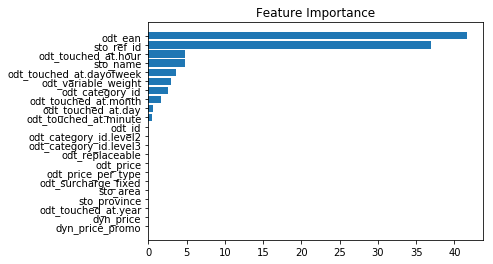

In [17]:
features_importance = training["scores"]["features_importance"]

features = list(features_importance.keys())
importances = list(features_importance.values())
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
num = len(features_importance)
plt.barh(range(0, num), importances)
#plt.bar([0,1,2], [3,30,90])

# Add feature names as x-axis labels
#plt.xticks(range(0, num), features, rotation=90)
plt.yticks(range(0, num), features)
plt.gca().invert_yaxis()
# Show plot
plt.show()

In [18]:
## Prediction

In [19]:
samples_filename = os.path.join(factory.get_artifacts_directory(), "training-samples.json")
data = pd.read_json(samples_filename, orient="records")
data

,dyn_price,dyn_price_promo,dyn_purchased,odt_category_id,odt_category_id.level2,odt_category_id.level3,odt_ean,odt_id,odt_price,odt_price_per_type,odt_replaceable,odt_surcharge_fixed,odt_touched_at.day,odt_touched_at.dayofweek,odt_touched_at.hour,odt_touched_at.minute,odt_touched_at.month,odt_touched_at.year,odt_variable_weight,sto_area,sto_name,sto_province,sto_ref_id
0,10.61,1.000000,1,431,0,0,8000500009673,20577832,10.61,35.36,2,0.00,17,6,16,19,2,2019,0,PD1,auchan,PD,233
1,2.39,1.000000,1,2304,0,0,5410076469123,15157711,2.39,3.60,3,0.00,20,5,12,38,10,2018,0,BO1,conad,BO,3735
2,5.35,0.745794,0,6223,0,0,8012431086159,19326976,5.35,0.01,3,-1.36,25,4,8,41,1,2019,0,TO3,pam,TO,1330
3,2.55,0.623529,0,88,0,0,8003100818331,15976069,2.55,0.01,3,-0.96,9,4,14,48,11,2018,0,TO2,mercatò,TO,1295
4,2.15,1.000000,1,254,0,0,3000047033501,12146113,2.15,8.00,3,0.00,4,2,17,31,7,2018,0,TO2,bennet,TO,1199
5,1.19,1.000000,1,288,0,0,920476922,17359247,1.19,11.00,3,0.00,10,0,14,6,12,2018,0,RM6,lidl,RM,5269
6,1.19,1.000000,1,702,0,0,4100130923784,12141173,1.19,1.00,2,0.00,4,2,15,28,7,2018,0,PD1,conad superstore,PD,5057
7,2.69,1.000000,1,298,0,0,8003170054097,15138689,2.69,14.00,1,0.00,19,4,13,0,10,2018,0,RN1,conad superstore,RN,5215
8,2.09,1.000000,1,596,0,0,8004263510025,19585368,2.09,0.01,1,0.00,29,1,21,52,1,2019,0,TO2,pam,TO,1332
9,1.55,1.000000,1,841,0,0,8009470060271,16203139,1.55,10.32,1,0.00,13,1,17,41,11,2018,0,VI1,interspar,VI,191


In [20]:
if not isinstance(data, pd.DataFrame):
    data = pd.DataFrame.from_dict(data, orient="columns")

# when 
if not "odt_touched_at" in data.columns:
    data["odt_touched_at"] = pd.Timestamp.now()
    
data

,dyn_price,dyn_price_promo,dyn_purchased,odt_category_id,odt_category_id.level2,odt_category_id.level3,odt_ean,odt_id,odt_price,odt_price_per_type,odt_replaceable,odt_surcharge_fixed,odt_touched_at.day,odt_touched_at.dayofweek,odt_touched_at.hour,odt_touched_at.minute,odt_touched_at.month,odt_touched_at.year,odt_variable_weight,sto_area,sto_name,sto_province,sto_ref_id,odt_touched_at
0,10.61,1.000000,1,431,0,0,8000500009673,20577832,10.61,35.36,2,0.00,17,6,16,19,2,2019,0,PD1,auchan,PD,233,2019-04-24 08:25:57.566890
1,2.39,1.000000,1,2304,0,0,5410076469123,15157711,2.39,3.60,3,0.00,20,5,12,38,10,2018,0,BO1,conad,BO,3735,2019-04-24 08:25:57.566890
2,5.35,0.745794,0,6223,0,0,8012431086159,19326976,5.35,0.01,3,-1.36,25,4,8,41,1,2019,0,TO3,pam,TO,1330,2019-04-24 08:25:57.566890
3,2.55,0.623529,0,88,0,0,8003100818331,15976069,2.55,0.01,3,-0.96,9,4,14,48,11,2018,0,TO2,mercatò,TO,1295,2019-04-24 08:25:57.566890
4,2.15,1.000000,1,254,0,0,3000047033501,12146113,2.15,8.00,3,0.00,4,2,17,31,7,2018,0,TO2,bennet,TO,1199,2019-04-24 08:25:57.566890
5,1.19,1.000000,1,288,0,0,920476922,17359247,1.19,11.00,3,0.00,10,0,14,6,12,2018,0,RM6,lidl,RM,5269,2019-04-24 08:25:57.566890
6,1.19,1.000000,1,702,0,0,4100130923784,12141173,1.19,1.00,2,0.00,4,2,15,28,7,2018,0,PD1,conad superstore,PD,5057,2019-04-24 08:25:57.566890
7,2.69,1.000000,1,298,0,0,8003170054097,15138689,2.69,14.00,1,0.00,19,4,13,0,10,2018,0,RN1,conad superstore,RN,5215,2019-04-24 08:25:57.566890
8,2.09,1.000000,1,596,0,0,8004263510025,19585368,2.09,0.01,1,0.00,29,1,21,52,1,2019,0,TO2,pam,TO,1332,2019-04-24 08:25:57.566890
9,1.55,1.000000,1,841,0,0,8009470060271,16203139,1.55,10.32,1,0.00,13,1,17,41,11,2018,0,VI1,interspar,VI,191,2019-04-24 08:25:57.566890


In [21]:
# generate predictions
results = factory.run_plugin(data, action="predict", settings = [
    {
        "name": "analitico.plugin.AugmentDatesPlugin",
        "schema": {
            "columns": [
                { "name": "odt_touched_at" }
            ]
        }
    },
    {
        "name": "s24.plugin.AugmentCategoriesPlugin",
        "schema": {
          "columns": [
            { "name": "odt_category_id" }
          ]
        }
    },
    {
        "name": "s24.plugin.OutOfStockPreprocessPlugin"
    },
    {
        "name": "analitico.plugin.CatBoostClassifierPlugin"
    }
])

AugmentCategoriesPlugin: data is already augmented


In [22]:
results

OrderedDict([('type', 'analitico/prediction'),
             ('performance',
              {'cpu_count': 12, 'loading_ms': 170, 'total_ms': 213}),
             ('records',
              [{'odt_id': 20577832,
                'odt_ean': '8000500009673',
                'odt_category_id': 431,
                'odt_category_id.level2': 0,
                'odt_category_id.level3': 0,
                'odt_replaceable': 2,
                'odt_variable_weight': 0,
                'odt_price': 10.61,
                'odt_price_per_type': 35.36,
                'odt_surcharge_fixed': 0.0,
                'sto_name': 'auchan',
                'sto_area': 'PD1',
                'sto_province': 'PD',
                'sto_ref_id': 233,
                'odt_touched_at.year': 2019,
                'odt_touched_at.month': 4,
                'odt_touched_at.day': 24,
                'odt_touched_at.hour': 8,
                'odt_touched_at.minute': 25,
                'odt_touched_at.dayofweek': 2,
    

In [23]:
data

,dyn_price,dyn_price_promo,dyn_purchased,odt_category_id,odt_category_id.level2,odt_category_id.level3,odt_ean,odt_id,odt_price,odt_price_per_type,odt_replaceable,odt_surcharge_fixed,odt_touched_at.day,odt_touched_at.dayofweek,odt_touched_at.hour,odt_touched_at.minute,odt_touched_at.month,odt_touched_at.year,odt_variable_weight,sto_area,sto_name,sto_province,sto_ref_id,odt_touched_at
0,10.61,1.000000,1,431,0,0,8000500009673,20577832,10.61,35.36,2,0.00,24,2,8,25,4,2019,0,PD1,auchan,PD,233,2019-04-24 08:25:57.566890
1,2.39,1.000000,1,2304,0,0,5410076469123,15157711,2.39,3.60,3,0.00,24,2,8,25,4,2019,0,BO1,conad,BO,3735,2019-04-24 08:25:57.566890
2,5.35,0.745794,0,6223,0,0,8012431086159,19326976,5.35,0.01,3,-1.36,24,2,8,25,4,2019,0,TO3,pam,TO,1330,2019-04-24 08:25:57.566890
3,2.55,0.623529,0,88,0,0,8003100818331,15976069,2.55,0.01,3,-0.96,24,2,8,25,4,2019,0,TO2,mercatò,TO,1295,2019-04-24 08:25:57.566890
4,2.15,1.000000,1,254,0,0,3000047033501,12146113,2.15,8.00,3,0.00,24,2,8,25,4,2019,0,TO2,bennet,TO,1199,2019-04-24 08:25:57.566890
5,1.19,1.000000,1,288,0,0,920476922,17359247,1.19,11.00,3,0.00,24,2,8,25,4,2019,0,RM6,lidl,RM,5269,2019-04-24 08:25:57.566890
6,1.19,1.000000,1,702,0,0,4100130923784,12141173,1.19,1.00,2,0.00,24,2,8,25,4,2019,0,PD1,conad superstore,PD,5057,2019-04-24 08:25:57.566890
7,2.69,1.000000,1,298,0,0,8003170054097,15138689,2.69,14.00,1,0.00,24,2,8,25,4,2019,0,RN1,conad superstore,RN,5215,2019-04-24 08:25:57.566890
8,2.09,1.000000,1,596,0,0,8004263510025,19585368,2.09,0.01,1,0.00,24,2,8,25,4,2019,0,TO2,pam,TO,1332,2019-04-24 08:25:57.566890
9,1.55,1.000000,1,841,0,0,8009470060271,16203139,1.55,10.32,1,0.00,24,2,8,25,4,2019,0,VI1,interspar,VI,191,2019-04-24 08:25:57.566890
